# Equação da onda em duas dimensões espaciais

* Vamos simular
$$ u_{tt} = c^2\Delta u.
$$

* Mais explicitamente
$$ u_{tt} = c^2(u_{xx} + u_{yy}).
$$

In [1]:
using DifferentialEquations
using Plots

## Aproximação em diferenças finitas do laplaciano

* Vamos considerar o caso de condições de contorno homogêneas do tipo Dirichlet, i.e. $u|_{\partial\Omega} = 0$.

* Usaremos uma malha $\{(x_i,y_j)\}_{i,j}$ de pontos em um domínio $\Omega = (0,L_x)\times(0,L_y)$.

* No interior, vamos aproximar
$$
\begin{align*}
  \Delta u(x,y) & = u_{xx}(x,y) + u_{yy}(x,y) \\
  & \approx \frac{u(x+h_x,y) - 2u(x,y) + u(x-h_x,y)}{h_x^2} + \frac{u(x, y+h_y) - 2u(x,y) + u(x,y-h_y)}{h_y^2}.
\end{align*}
$$

* Julia, assim como o Fortran, guarda *arrays* na memória em formato *column-major*, o que significa que eles são guardados coluna a coluna, ou seja, a primeira coluna inteira, de forma contígua, seguida da segunda coluna, e assim por diante. 

* Nesse sentido, é diferente do Python, que guarda cada linha de maneira contígua, chamada *row-major*.

* Por esse motivo, é mais rápido fazer o *loop* duplo com o *loop* interior percorrendo as linhas e o *loop* exterior, as colunas.

In [2]:
function δ²(u::Matrix{Float64}, hx2::Float64, hy2::Float64, ::Val{:dir})
    n, m = size(u)
    ddu = zero(u)
    for j = 2:m-1
        for i = 2:n-1
            ddu[i,j] = (u[i,j+1] - 2u[i,j] + u[i,j-1])/hx2 + 
                (u[i+1,j] - 2u[i,j] + u[i-1,j])/hy2
        end
    end
    return ddu
end

δ² (generic function with 1 method)

## Lei de evolução

* Nesse caso, fazemos, novamente, $U=(u,v)$, mas agora as discretizações de $u$ e $v$ são matrizes.

* Assim, definimos $U$ como um array de dimensões $N_x\times N_y \times 2$, onde
$$ u = U[:,:,1], \qquad v = U[:,:,2]
$$

In [3]:
function dUdt_onda2d!(dUdt, U, p, t)
    c2, hx2, hy2 = p
    u = U[:,:,1]
    v = U[:,:,2]
    dUdt[:,:,1] .= v
    dUdt[:,:,2] .= c2 * δ²(u, hx2, hy2, Val(:dir))
    return nothing
end

dUdt_onda2d! (generic function with 1 method)

In [4]:
c = 0.5 # velocidade de propagação da onda
Lx = 2π # comprimento na direção x do domínio [0,Lx]×[0,Ly]
Ly = π # comprimento na direção y do domínio [0,Lx]×[0,Ly]
Nx = 60 # número de pontos da malha na direção x
Ny = 40 # número de pontos da malha na direção x
hx = Lx/(Nx-1) # comprimento de cada partição da malha em x
hy = Ly/(Ny-1) # comprimento de cada partição da malha em y
x = range(0.0, Lx, length=Nx) # discretização espacial na direção x
y = range(0.0, Ly, length=Ny) # discretização espacial na direção y
σ = 0.5
u₀ = exp.(-(y .- Ly/2).^2/σ^2) * exp.(-(x .- Lx/2).^2/σ^2)' # condição inicial
u₀[1,:] .= u₀[end,:] .= 0
u₀[:,1] .= u₀[:,end] .= 0
v₀ = zero(u₀)
U₀ = fill(0.0, size(u₀)..., 2)
U₀[:,:,1] .= u₀ 
U₀[:,:,2] .= v₀
p = [c^2, hx^2, hy^2] # parâmetros
Tf = 25 # tempo final
τ = 0.1 # intervalos de tempo
tspan = (0.0,Tf) # intervalo de tempo
prob = ODEProblem(dUdt_onda2d!, U₀, tspan, p, saveat = τ)
nothing

In [5]:
sol = solve(prob, Tsit5())
sol.retcode

:Success

In [6]:
sol.u[1]

40×60×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0          0.0          0.0          …  0.0          0.0          0.0
 0.0  1.37868e-20  1.74884e-19  2.02597e-18     1.74884e-19  1.37868e-20  0.0
 0.0  3.5097e-20   4.45201e-19  5.15749e-18     4.45201e-19  3.5097e-20   0.0
 0.0  8.48262e-20  1.07601e-18  1.24652e-17     1.07601e-18  8.48262e-20  0.0
 0.0  1.94646e-19  2.46906e-18  2.86032e-17     2.46906e-18  1.94646e-19  0.0
 0.0  4.24049e-19  5.37901e-18  6.23139e-17  …  5.37901e-18  4.24049e-19  0.0
 0.0  8.77087e-19  1.11257e-17  1.28888e-16     1.11257e-17  8.77087e-19  0.0
 0.0  1.72236e-18  2.18479e-17  2.531e-16       2.18479e-17  1.72236e-18  0.0
 0.0  3.21115e-18  4.0733e-17   4.71877e-16     4.0733e-17   3.21115e-18  0.0
 0.0  5.68398e-18  7.21005e-17  8.35259e-16     7.21005e-17  5.68398e-18  0.0
 0.0  9.55211e-18  1.21167e-16  1.40368e-15  …  1.21167e-16  9.55211e-18  0.0
 0.0  1.52406e-17  1.93325e-16  2.2396e-15      1.93325e-16  1.52406e-17  0.0
 0.0  2.30866e-17  2.9285

┌ Info: Saved animation to 
│   fn = /Users/rrosa/Documents/git_repositories/modelagem_matematica/_assets/attachments/img/anim_onda2D_a.gif
└ @ Plots /Users/rrosa/.julia/packages/Plots/MzlNY/src/animation.jl:130


Plots.AnimatedGif("/Users/rrosa/Documents/git_repositories/modelagem_matematica/_assets/attachments/img/anim_onda2D_a.gif")
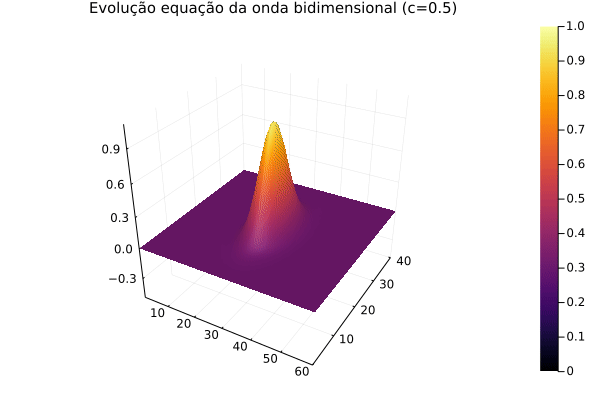

In [7]:
anim = @animate for (t,U) in zip(sol.t, sol.u)
    surface(U[:,:,1], zlims=(-0.5, 1.1), label="t=$(round(t,digits=2))", clims=(0.0, 1.0),
        title="Evolução equação da onda bidimensional (c=$c)", titlefont=10)
end
gif(anim, "../../../assets/attachments/img/anim_onda2D_a.gif", fps = 20)
nothing

![wave2d](../../../assets/attachments/img/anim_onda2D_a.gif)